In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [2]:
tracks = pd.read_csv('../data/tracks_meta.csv', index_col = 0)

For the purposes of this approach to modeling and for the subsequent recommender system, we'll be using the time-aggregated approach as described in the EDA notebook. The basic idea is to split each song into consecutive segments (10 by default) then take the average and standard deviation of the mel bands across that segment and use the ten segments as our representation of each song. This will allow us to attempt traditional classification methods and later to calculate similarities between the larger time-segments.

In [3]:
# Splits a full song into even segments, by default 10 segments of 3s
def audio_framer(song, idx, splits = 10):
    # Creating columns for returned dataframe
    index_list = [idx] * splits # Maintains index of original song
    timestamps = list(range(splits)) # Orders each segment for potential future use
    df  = pd.DataFrame({'song_index' : index_list, 'ts' : timestamps}) 
    

    # Each slice is aggregated then added into a list to create a dataframe
    slices = []
    for slice in np.array_split(song, splits, axis = 0):
        sliced = pd.concat(
            [
                pd.Series(
                    np.mean(slice, axis = 0)
                ),
                pd.Series(
                    np.std(slice, axis = 0)
                )
            ],
            axis = 0
        ).reset_index(drop = True)
        
        slices.append(sliced)

    # Returns a dataframe of size splits x 258
    return pd.concat([df, pd.DataFrame(slices)], axis = 1)

In [4]:
# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx)])


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
)

In [5]:
# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Mapping each genre to a number
map_genre = {
    'Hip-Hop': 0,
    'Pop' : 1,
    'Folk' : 2,
    'Rock' : 3,
    'Experimental' : 4,
    'International' : 5,
    'Electronic' : 6,
    'Instrumental' : 7
}

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

In [6]:
# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        # Standard Scaler because MinMax scaler had very slightly worse separation
        ('ss', StandardScaler()),
        ('pca', PCA())
    ]
).fit(X_train)

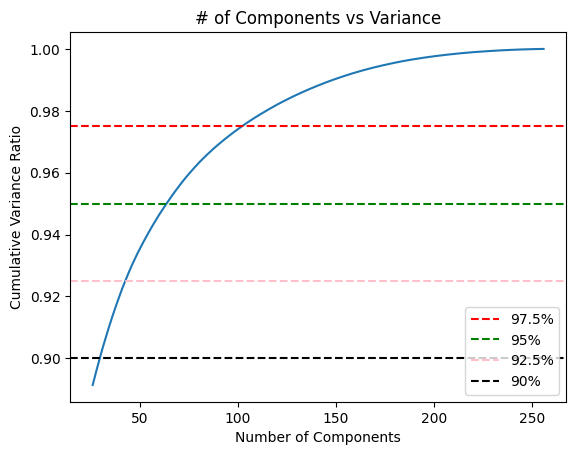

In [7]:
# Plotting cumulative variance to identify a cutoff value

sns.lineplot(
    x = range(26, 257),
    y = np.cumsum(pipe['pca'].explained_variance_ratio_)[25:]
    )

# 85% is omitted because it's before the 'elbow', normally 85% is the default cutoff
plt.axhline(0.975, linestyle = '--', color = 'red', label = '97.5%')
plt.axhline(0.95, linestyle = '--', color = 'green', label = '95%')
plt.axhline(0.925, linestyle = '--', color = 'pink', label = '92.5%')
plt.axhline(0.9, linestyle = '--', color = 'black', label = '90%')


plt.legend(loc = 'lower right')
plt.ylabel('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.title('# of Components vs Variance');

We're going to proceed with the first 100 components, ideally we'd take more but we don't want our similarity matrix down the line to be too computationally expensive and we'd like to save the transformed dataframe and pre-processing pipe later for use in an app so we'll take a (slightly) more conservative approach here.

In [8]:
# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        # Standard Scaler because MinMax scaler had very slightly worse separation
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100)),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, force_col_wise = True))
    ]
)#.fit(X_train)

pipe.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 63940, number of used features: 100
[LightGBM] [Info] Start training from score -2.082261
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.078504


Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=100)),
                ('lgb',
                 LGBMClassifier(force_col_wise=True, n_jobs=4,
                                random_state=42))])

In [9]:
pipe.score(X_train, y_train)

0.7661714106975289

In [10]:
pipe.score(X_test, y_test)

0.4179375

Before moving on, let's consider using a large number of splits per song to see if that helps or hurts our approach.

In [11]:
# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx, 20)]) # 1.5s intervals instead of 3s


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
)

In [12]:
# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Mapping each genre to a number
map_genre = {
    'Hip-Hop': 0,
    'Pop' : 1,
    'Folk' : 2,
    'Rock' : 3,
    'Experimental' : 4,
    'International' : 5,
    'Electronic' : 6,
    'Instrumental' : 7
}

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

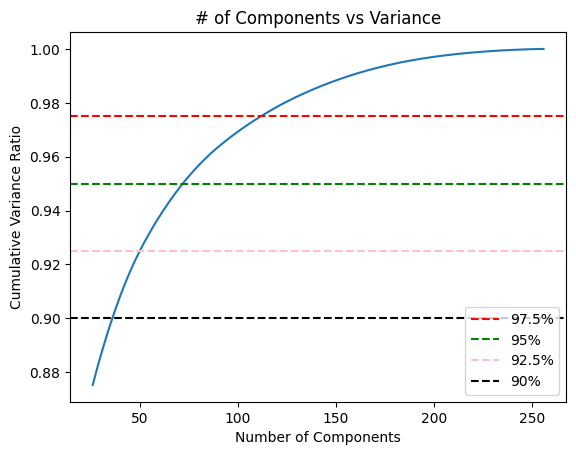

In [13]:
# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        # Standard Scaler because MinMax scaler had very slightly worse separation
        ('ss', StandardScaler()),
        ('pca', PCA())
    ]
).fit(X_train)

# Plotting cumulative variance to identify a cutoff value

sns.lineplot(
    x = range(26, 257),
    y = np.cumsum(pipe['pca'].explained_variance_ratio_)[25:]
    )

# 85% is omitted because it's before the 'elbow', normally 85% is the default cutoff
plt.axhline(0.975, linestyle = '--', color = 'red', label = '97.5%')
plt.axhline(0.95, linestyle = '--', color = 'green', label = '95%')
plt.axhline(0.925, linestyle = '--', color = 'pink', label = '92.5%')
plt.axhline(0.9, linestyle = '--', color = 'black', label = '90%')


plt.legend(loc = 'lower right')
plt.ylabel('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.title('# of Components vs Variance');

Interestingly, we actually have less cumulative variance explained at every number of components if we split songs into 20 segments instead of 10. This means, at the same number of components we've more or less gotten slightly worse results while also conveniently doubling the number of rows (and therefore amount of computation). Let's quickly check performance at the same number of components before we dismiss this out of hand though.

In [14]:
# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        # Standard Scaler because MinMax scaler had very slightly worse separation
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100)),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, force_col_wise = True))
    ]
)#.fit(X_train)

pipe.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 127880, number of used features: 100
[LightGBM] [Info] Start training from score -2.082261
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.078504
[LightGBM] [Info] Start training from score -2.079754
[LightGBM] [Info] Start training from score -2.078504


Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=100)),
                ('lgb',
                 LGBMClassifier(force_col_wise=True, n_jobs=4,
                                random_state=42))])

In [15]:
pipe.score(X_train, y_train)

0.6660775727244291

In [16]:
pipe.score(X_test, y_test)

0.4208125

We actually get better performance on our test set, granted only slightly. Our training set is also substantially less overfit which is not bad at all. We'll still proceed with the original 10-split approach for computational efficiency but there may actually be some merit to this more granular line of thought.

In [17]:
# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx)])


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
)

# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

preprocessing = Pipeline(
    [
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100))
    ]
)

In [21]:
lgbm_pipe = Pipeline(
    [
        ('pre', preprocessing),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, verbose = -100))
    ]
)

params = {
    'lgb__n_estimators' : [75, 100, 150],
    'lgb__reg_alpha' : [0, 0.1, 1, 5],
    'lgb__reg_lambda' : [0, 0.1, 1, 5]
}


lgbm_grid = GridSearchCV(
    lgbm_pipe,
    param_grid = params,
    cv = 5
).fit(X_train, y_train)

In [22]:
lgbm_grid.best_score_

0.4572880825774163

In [23]:
lgbm_grid.score(X_test, y_test)

0.425375

In [24]:
lgbm_grid.best_estimator_

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ss', StandardScaler()),
                                 ('pca', PCA(n_components=100))])),
                ('lgb',
                 LGBMClassifier(n_estimators=150, n_jobs=4, random_state=42,
                                reg_alpha=5, reg_lambda=1, verbose=-100))])